<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils import data

#Utils 

In [2]:
import multiprocessing
def get_workers():
  return multiprocessing.cpu_count()


In [3]:
class Accumulator: 
  """For accumulating sums over `n` variables.""" 
  def __init__(self, n):
    self.data = [0.0] * n 
    
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)] 
    
  def reset(self):
    self.data = [0.0] * len(self.data)
  
  def __getitem__(self, idx): 
    return self.data[idx]

In [4]:
def load_fashion_mnist(batch_size,resize=None):
  trans=[transforms.ToTensor()]
  if resize:
    trans.insert(0,transforms.Resize(resize))
  trans=transforms.Compose(trans)

  mnist_train=torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
  mnist_test=torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

  return data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_workers()),data.DataLoader(mnist_test,batch_size,shuffle=False,num_workers=get_workers())



In [5]:
def accuracy(y_hat,y):
  """Compute the number of correct predictions.""" 
  if y_hat.shape[0]>1 and y_hat.shape[1]>1:
    y_hat=y_hat.argmax(axis=1)
  cmp=y_hat.type(y.dtype)==y
  return float(cmp.type(y.dtype).sum())

In [6]:
def evaluate_accuracy_gpu(net,test_iter,device=None):
  """Compute the accuracy for a model on a dataset using a GPU."""
  if isinstance (net,nn.Module):
    net.eval()
    if not device:
      device=next(iter(net.parameters())).device

    # No. of correct predictions, no. of predictions 
    metric =Accumulator(2)

    with torch.no_grad():
      for X,y in test_iter:
        if isinstance(X, list):
          # Required for BERT Fine-tuning (to be covered later) 
          X = [x.to(device) for x in X]

        else:
          X=X.to(device)
        
        y=y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
      
    return metric[0] / metric[1]

In [7]:
def try_gpu(i=0):
  """Return gpu(i) if exists, otherwise return cpu().""" 
  if torch.cuda.device_count() >= i + 1:
    return torch.device(f'cuda:{i}') 
  return torch.device('cpu')

In [22]:
def train(net,train_iter,test_iter,loss,optimizer,num_epochs,learning_rate,device):
  def init_weights(layer):
    if isinstance(layer,nn.Linear) or isinstance(layer,nn.Conv2d):
      nn.init.xavier_uniform_(layer.weight)
  net.apply(init_weights)
  print('training on', device)
  net.to(device)

  for epoch in range(num_epochs):
    metric=Accumulator(3) # Sum of training loss, sum of training accuracy, no. of examples
    net.train()

    for X,y in train_iter:
      X,y=X.to(device), y.to(device)
      optimizer.zero_grad()
      y_hat=net(X)
      l=loss(y_hat,y)
      l.backward()
      optimizer.step()

      with torch.no_grad():
        metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])

      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]

    test_acc = evaluate_accuracy_gpu(net, test_iter)

    print(f'epcoch:{epoch+1} 'f'loss {train_l:.3f}, train acc {train_acc:.3f},'f'test acc {test_acc:.3f}')

# AlexNet 

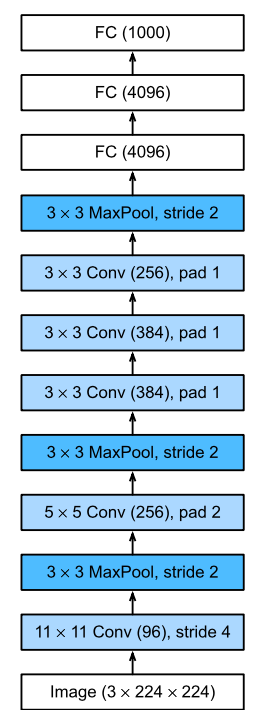

In [ ]:
net=nn.Sequential(
    nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
    )


In [ ]:
X = torch.randn(1, 1, 224, 224) 
for layer in net:
  X=layer(X)
  print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [ ]:
batch_size=128
lr, num_epochs = 0.01, 10

train_iter, test_iter = load_fashion_mnist(batch_size=batch_size,resize=224)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 1.322, train acc 0.510,test acc 0.707
epcoch:2 loss 0.658, train acc 0.754,test acc 0.792
epcoch:3 loss 0.543, train acc 0.797,test acc 0.812
epcoch:4 loss 0.477, train acc 0.825,test acc 0.826
epcoch:5 loss 0.433, train acc 0.841,test acc 0.856
epcoch:6 loss 0.400, train acc 0.853,test acc 0.855
epcoch:7 loss 0.379, train acc 0.861,test acc 0.867
epcoch:8 loss 0.360, train acc 0.868,test acc 0.875
epcoch:9 loss 0.343, train acc 0.874,test acc 0.870
epcoch:10 loss 0.330, train acc 0.878,test acc 0.882


# VGG-11



In [ ]:
def vgg_block(num_convs,in_channels,out_channels):
  layers=[]
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
    layers.append(nn.ReLU())
    in_channels=out_channels
  
  layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
  return nn.Sequential(*layers)

The following variable conv_arch consists of a list of tuples (one per block), where each contains two values: the number of convolutional layers and the number of output channels, which are precisely the arguments required to call the vgg_block function. The fully-connected part of the VGG network is identical to that covered in AlexNet

 **Since this network uses 8 convolutional layers and 3 fully-connected layers, it is often called VGG-11.**

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [ ]:
def vgg(conv_arch):
  conv_blocks=[]
  in_channels=1

  for num_convs,out_channels in conv_arch:
    conv_blocks.append(vgg_block(num_convs,in_channels,out_channels))
    in_channels=out_channels
  
  return nn.Sequential(*conv_blocks,
                       nn.Flatten(),
                       nn.Linear(out_channels * 7 * 7, 4096),nn.ReLU(), nn.Dropout(0.5),
                       nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), 
                       nn.Linear(4096, 10)
                       )
  
net = vgg(conv_arch)



In [ ]:
X = torch.randn(size=(1, 1, 224, 224)) 
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.01, 1, 128
train_iter, test_iter = load_fashion_mnist(batch_size, resize=224)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)

In [ ]:
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 1.607, train acc 0.431,test acc 0.711


# Network in Network 

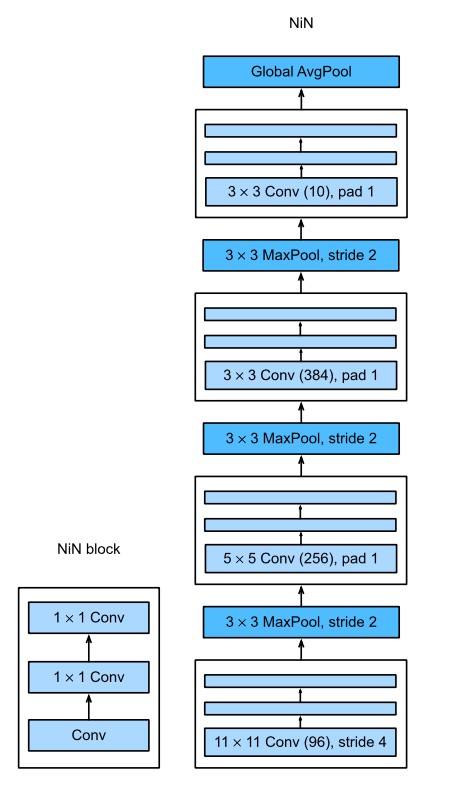

The original NiN network was proposed shortly after AlexNet and clearly draws some inspiration. NiN uses convolutional layers with window shapes of 11×11, 5×5, and 3×3, and the corresponding numbers of output channels are the same as in AlexNet. Each NiN block is followed by a maximum pooling layer with a stride of 2 and a window shape of 3 × 3.

In [ ]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
                  nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
                  nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
                  nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
                  )
  

In [ ]:
net=nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # There are 10 label classes
    nin_block(384, 10, kernel_size=3, strides=1, padding=1), #Transform to batch_size X labels X h X w
    nn.AdaptiveAvgPool2d((1, 1)), #Transform to batch_size X labels X 1 X 1
    nn.Flatten() # Transform to batch_size X labels
)

In [ ]:
X = torch.rand(size=(1, 1, 224, 224)) 
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.1, 5, 128
train_iter, test_iter = load_fashion_mnist(batch_size, resize=224)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)

In [ ]:
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 2.303, train acc 0.100,test acc 0.100
epcoch:2 loss 2.235, train acc 0.123,test acc 0.150
epcoch:3 loss 1.799, train acc 0.324,test acc 0.281
epcoch:4 loss 1.564, train acc 0.433,test acc 0.458
epcoch:5 loss 1.490, train acc 0.453,test acc 0.465


# Inception

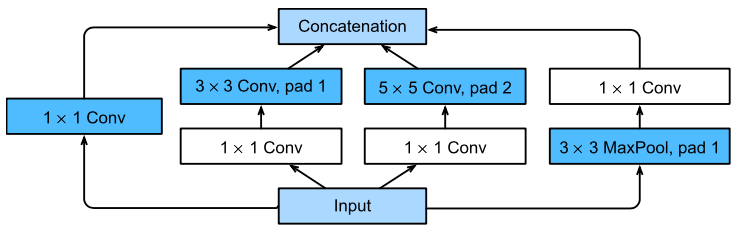

The four paths all use appropriate padding to give the input and output the same height and width. Finally, the outputs along each path are concatenated along the channel dimension and comprise the blockʼs output. **The commonly-tuned hyperparameters of the Inception block are the number of output channels per layer.**

In [ ]:
from torch.nn import functional as F #Use this

class Inception(nn.Module):
  # `c1`--`c4` are the number of output channels for each path 
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    # Path 1 is a single 1 x 1 convolutional layer
    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

    # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
    # convolutional layer
    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1) 
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1) 
    
    # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
    # convolutional layer
    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1) 
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2) 
    
    # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1 # convolutional layer
    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1) 
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self,X):
    p1=F.relu(self.p1_1(X))
    p2=F.relu(self.p2_2(self.p2_1(X)))
    p3=F.relu(self.p3_2(self.p3_1(X)))
    p4=F.relu(self.p4_2(self.p4_1(X)))
    #Concatenate the outputs on the channel dimension
    return torch.cat((p1,p2,p3,p4),dim=1)

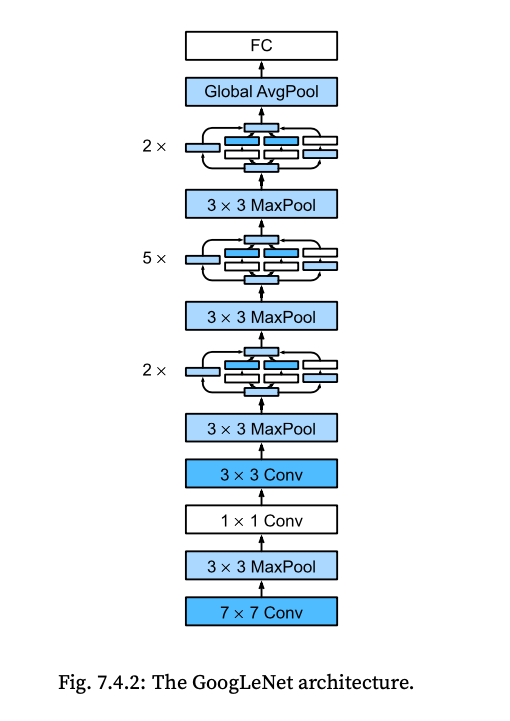

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [ ]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series. The number of output channels of the first Inception block is 64 + 128 + 32 + 32 = 256, and the number-of-output-channel ratioamongthefourpathsis64 : 128 : 32 : 32 = 2 : 4 : 1 : 1. The second and third paths first reduce the number of input channels to 96/192 = 1/2 and 16/192 = 1/12, respectively, and then connect the second convolutional layer. The number of output channels of the second Inception block is increased to 128 + 192 + 96 + 64 = 480, and the number-of-output-channel ratio among thefourpathsis128 : 192 : 96 : 64 = 4 : 6 : 3 : 2. The second and third paths first reduce the number of input channels to 128/256 = 1/2 and 32/256 = 1/8, respectively.

In [ ]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

The fourth module is more complicated. It connects five Inception blocks in series, and they have 192+208+48+64 = 512, 160+224+64+64 = 512, 128+256+64+64 = 512, 112+288+64+64 = 528, and 256+320+128+128 = 832 output channels, respectively. The number of channels assigned to these paths is similar to that in the third module: the second path with the 3×3 convolutional layer outputs the largest number of channels, followed by the first path with only the 1 × 1 convolutional layer, the third path with the 5×5 convolutional layer, and the fourth path with the 3×3 maximum pooling layer. The second and third paths will first reduce the number of channels according to the ratio. These ratios are slightly different in different Inception blocks.

In [ ]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

The fifth module has two Inception blocks with 256 + 320 + 128 + 128 = 832 and 384 + 384 + 128 + 128 = 1024 output channels. The number of channels assigned to each path is the same as that in the third and fourth modules, but differs in specific values. It should be noted that the fifth block is followed by the output layer. **This block uses the global average pooling layer to change the height and width of each channel to 1, just as in NiN. Finally, we turn the output into a two-dimensional array followed by a fully-connected layer whose number of outputs is the number of label classes.**

In [ ]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())


In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
X = torch.rand(size=(1, 1, 96, 96)) 
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.1, 1, 128
train_iter, test_iter = load_fashion_mnist(batch_size, resize=224)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)

In [ ]:
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 2.263, train acc 0.151,test acc 0.215


# Batch Normalisation

In [ ]:
def batch_norm(X,scale,shift,moving_mean,moving_var,eps,momentum):
  # Use `is_grad_enabled` to determine whether the current mode is training # mode or prediction mode
  if not torch.is_grad_enabled():
    # If it is prediction mode, directly use the mean and variance
    # obtained by moving average
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)

  else:
    assert len(X.shape) in (2, 4) 
    if len(X.shape) == 2:
      # When using a fully-connected layer, calculate the mean and # variance on the feature dimension
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    
    else:
      # When using a two-dimensional convolutional layer, calculate the
      # mean and variance on the channel dimension (axis=1). Here we
      # need to maintain the shape of `X`, so that the broadcasting # operation can be carried out later
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

    # In training mode, the current mean and variance are used for the # standardization
    X_hat = (X - mean) / torch.sqrt(var + eps)
    # Update the mean and variance using moving average
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var

  Y=scale*X_hat+shift
  return Y,moving_mean,moving_var


In [ ]:
class BatchNorm(nn.Module):
  # `num_features`: the number of outputs for a fully-connected layer
  # or the number of output channels for a convolutional layer. 
  #`num_dims`: # 2 for a fully-connected layer and 4 for a convolutional layer
  def __init__(self,num_features,num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features) 
    else:
      shape = (1, num_features, 1, 1)
    # The scale parameter and the shift parameter (model parameters) are
    # initialized to 1 and 0, respectively
    self.scale = nn.Parameter(torch.ones(shape))
    self.shift = nn.Parameter(torch.zeros(shape))
    # The variables that are not model parameters are initialized to 0 and 1 
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self,X):
    # If `X` is not on the main memory, copy `moving_mean` and 
    # `moving_var` to the device where `X` is located
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # Save the updated `moving_mean` and `moving_var` 
    Y, self.moving_mean, self.moving_var = batch_norm(X, self.scale, self.shift, self.moving_mean,self.moving_var, eps=1e-5, momentum=0.9) 
    return Y


In [ ]:
y_try,m_mean_try,m_std_try=batch_norm(torch.rand(5,10), nn.Parameter(torch.ones((1,10))),nn.Parameter(torch.zeros((1,10))), torch.zeros((1,10)),torch.ones((1,10)), eps=1e-5, momentum=0.9) 

##Batch Norm After Activation

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),nn.Sigmoid(),BatchNorm(6, num_dims=4),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),BatchNorm(16, num_dims=4),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120),nn.Sigmoid(),BatchNorm(120, num_dims=2),
    nn.Linear(120, 84),nn.Sigmoid(),BatchNorm(84, num_dims=2), 
    nn.Linear(84, 10))

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_fashion_mnist(batch_size)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)

In [ ]:
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 0.828, train acc 0.714,test acc 0.768
epcoch:2 loss 0.451, train acc 0.830,test acc 0.840
epcoch:3 loss 0.385, train acc 0.857,test acc 0.841
epcoch:4 loss 0.353, train acc 0.869,test acc 0.843
epcoch:5 loss 0.329, train acc 0.877,test acc 0.830
epcoch:6 loss 0.312, train acc 0.884,test acc 0.866
epcoch:7 loss 0.298, train acc 0.890,test acc 0.878
epcoch:8 loss 0.288, train acc 0.893,test acc 0.869
epcoch:9 loss 0.275, train acc 0.897,test acc 0.858
epcoch:10 loss 0.266, train acc 0.900,test acc 0.880


In [ ]:
net[2].scale, net[2].shift,net[2].scale.shape, net[2].shift.shape

(Parameter containing:
 tensor([[[[ 1.1882]],
 
          [[ 0.5413]],
 
          [[ 0.6186]],
 
          [[-0.5357]],
 
          [[ 2.2327]],
 
          [[ 2.0171]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[[[ 0.1562]],
 
          [[ 0.0850]],
 
          [[ 0.1506]],
 
          [[-0.9512]],
 
          [[-0.4452]],
 
          [[ 0.2629]]]], device='cuda:0', requires_grad=True),
 torch.Size([1, 6, 1, 1]),
 torch.Size([1, 6, 1, 1]))

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),nn.Sigmoid(),nn.BatchNorm2d(6),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),nn.Sigmoid(),nn.BatchNorm2d(16),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(256, 120),nn.Sigmoid(),nn.BatchNorm1d(120),
    nn.Linear(120, 84), nn.Sigmoid(),nn.BatchNorm1d(84),
    nn.Linear(84, 10))

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_fashion_mnist(batch_size)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 0.750, train acc 0.733,test acc 0.811
epcoch:2 loss 0.431, train acc 0.840,test acc 0.834
epcoch:3 loss 0.371, train acc 0.862,test acc 0.829
epcoch:4 loss 0.342, train acc 0.871,test acc 0.797
epcoch:5 loss 0.321, train acc 0.880,test acc 0.841
epcoch:6 loss 0.305, train acc 0.885,test acc 0.841
epcoch:7 loss 0.294, train acc 0.889,test acc 0.870
epcoch:8 loss 0.285, train acc 0.892,test acc 0.859
epcoch:9 loss 0.275, train acc 0.896,test acc 0.879
epcoch:10 loss 0.267, train acc 0.900,test acc 0.864


##Batch Norm Before Activation

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),BatchNorm(6, num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),BatchNorm(16, num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120),BatchNorm(120, num_dims=2),nn.Sigmoid(),
    nn.Linear(120, 84),BatchNorm(84, num_dims=2),nn.Sigmoid(),
    nn.Linear(84, 10))

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_fashion_mnist(batch_size)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)

In [ ]:
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 0.748, train acc 0.732,test acc 0.755
epcoch:2 loss 0.485, train acc 0.822,test acc 0.759
epcoch:3 loss 0.408, train acc 0.851,test acc 0.815
epcoch:4 loss 0.371, train acc 0.865,test acc 0.846
epcoch:5 loss 0.339, train acc 0.875,test acc 0.846
epcoch:6 loss 0.321, train acc 0.882,test acc 0.835
epcoch:7 loss 0.305, train acc 0.888,test acc 0.847
epcoch:8 loss 0.295, train acc 0.891,test acc 0.871
epcoch:9 loss 0.277, train acc 0.898,test acc 0.819
epcoch:10 loss 0.273, train acc 0.899,test acc 0.864


In [ ]:
net[1].scale, net[1].shift

(Parameter containing:
 tensor([[[[2.6900]],
 
          [[0.3682]],
 
          [[2.1615]],
 
          [[2.6361]],
 
          [[2.7074]],
 
          [[3.7171]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[[[-2.7606]],
 
          [[ 0.2276]],
 
          [[-2.5669]],
 
          [[ 3.0449]],
 
          [[ 2.8688]],
 
          [[-0.0693]]]], device='cuda:0', requires_grad=True))

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(256, 120),nn.BatchNorm1d(120),nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_fashion_mnist(batch_size)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 0.741, train acc 0.732,test acc 0.751
epcoch:2 loss 0.483, train acc 0.824,test acc 0.807
epcoch:3 loss 0.417, train acc 0.848,test acc 0.819
epcoch:4 loss 0.376, train acc 0.861,test acc 0.836
epcoch:5 loss 0.346, train acc 0.873,test acc 0.804
epcoch:6 loss 0.325, train acc 0.882,test acc 0.858
epcoch:7 loss 0.312, train acc 0.885,test acc 0.846
epcoch:8 loss 0.299, train acc 0.890,test acc 0.851
epcoch:9 loss 0.288, train acc 0.893,test acc 0.817
epcoch:10 loss 0.282, train acc 0.896,test acc 0.870


# Resnet

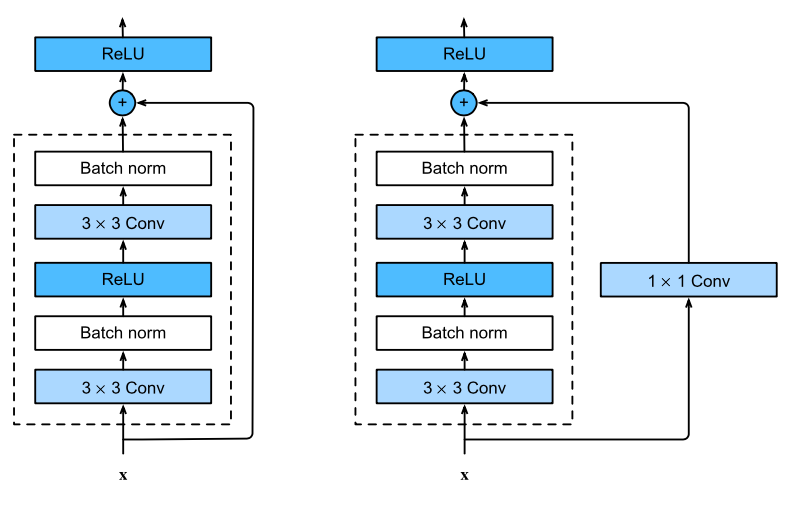

The residual block has two 3 × 3 con- volutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need
to introduce an additional 1 × 1 convolutional layer to transform the input into the desired shape for the addition operation.

**This code generates two types of networks: one where we add the input to the output before ap- plying the ReLU nonlinearity whenever use_1x1conv=False, and one where use_1X1conv=True so that we adjust channels and resolution**

In [ ]:
from torch.nn import functional as F
class Residual(nn.Module):
  def __init__(self,in_channels,out_channels,use_1x1conv=False,strides=1):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=strides)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)

    if use_1x1conv:
      self.conv3=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=strides)
    else:
      self.conv3=None
    
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self,X):
    Y=self.bn1(F.relu(self.conv1(X)))
    Y=self.conv2(Y)
    if self.conv3:
      X=self.conv3(X)
    Y+=X
    return self.bn2(F.relu(Y))


In [ ]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6) 
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [ ]:
#We also have the option to halve the output height and width while increasing the number of
#output channels.
blk = Residual(3,6, use_1x1conv=True, strides=2) 
blk(X).shape

torch.Size([4, 6, 3, 3])

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the 7×7 convolutional layer with 64 output channels and a stride of 2 is followed by the 3×3 maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each ReLU layer in ResNet.ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),nn.ReLU(),nn.BatchNorm2d(64),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                  )


In [ ]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block: 
      blk.append(Residual(input_channels, num_channels,use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

In [ ]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) #2X2 conv layers
b3 = nn.Sequential(*resnet_block(64, 128, 2))  #2 X 3 conv layers
b4 = nn.Sequential(*resnet_block(128, 256, 2)) #2 X 3 conv layers
b5 = nn.Sequential(*resnet_block(256, 512, 2)) #2 X 3 conv layers

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(), nn.Linear(512, 10))

In [ ]:
X = torch.rand(size=(1, 1, 224, 224)) 
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.05, 7, 256
train_iter, test_iter = load_fashion_mnist(batch_size, resize=96)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 0.431, train acc 0.846,test acc 0.837
epcoch:2 loss 0.255, train acc 0.906,test acc 0.867
epcoch:3 loss 0.193, train acc 0.929,test acc 0.901
epcoch:4 loss 0.149, train acc 0.946,test acc 0.904
epcoch:5 loss 0.111, train acc 0.962,test acc 0.907
epcoch:6 loss 0.078, train acc 0.974,test acc 0.857
epcoch:7 loss 0.052, train acc 0.983,test acc 0.914


# DenseNet 

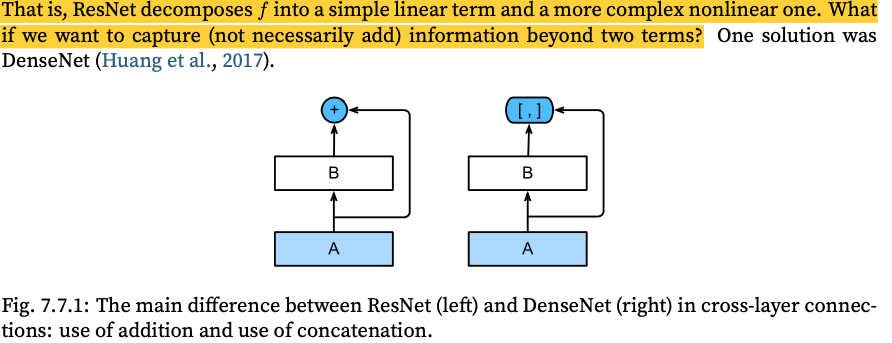

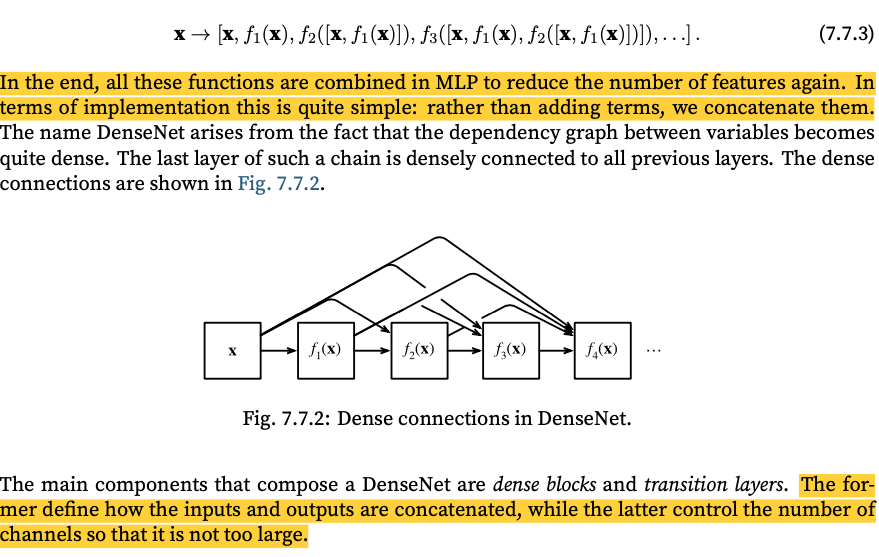

In [9]:
def conv_block(input_channels, num_channels): 
  return nn.Sequential(nn.ReLU(),nn.BatchNorm2d(input_channels),nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [10]:
layer = []

for i in range(2):
  layer.append(conv_block(10 * i + 3, 10))

net = nn.Sequential(*layer)
net

Sequential(
  (0): Sequential(
    (0): ReLU()
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): Sequential(
    (0): ReLU()
    (1): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(13, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

When using an input with 3 channels, we will get an output with 3+2×10 = 23 channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.


In [13]:
X = torch.randn(4, 3, 8, 8)
for blk in net:
  Y = blk(X)
  # Concatenate the input and output of each block on the channel # dimension
  print(X.shape,Y.shape)
  X = torch.cat((X, Y), dim=1)
  print(layer.__class__.__name__,'output shape:\t',X.shape)

torch.Size([4, 3, 8, 8]) torch.Size([4, 10, 8, 8])
list output shape:	 torch.Size([4, 13, 8, 8])
torch.Size([4, 13, 8, 8]) torch.Size([4, 10, 8, 8])
list output shape:	 torch.Size([4, 23, 8, 8])


In [14]:
class DenseBlock(nn.Module):
  def __init__(self, num_convs, input_channels, out_channels):
    super(DenseBlock, self).__init__()
    layer=[]
    for i in range(num_convs):
      layer.append(conv_block(out_channels*i+input_channels,out_channels))
    self.net=nn.Sequential(*layer)

  def forward(self,X):
    for blk in self.net:
      Y=blk(X)
      # Concatenate the input and output of each block on the channel dimension
      X = torch.cat((X, Y), dim=1)
    return X


A transition layer is used to control the complexity of the model. It reduces the number of channels by using the 1 × 1 convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.

In [15]:
def transition_block(input_channels, out_channels):
  return nn.Sequential(
      nn.ReLU(),nn.BatchNorm2d(input_channels),nn.Conv2d(input_channels, out_channels, kernel_size=1),
      nn.AvgPool2d(kernel_size=2, stride=2)
      )

In [16]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),nn.BatchNorm2d(64), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

Then, similar to the four modules made up of residual blocks that ResNet uses, DenseNet uses four dense blocks. Similar to ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 model in Section 7.6. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.
In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels.

In [23]:
# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32 
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
  print(num_channels)
  blks.append(DenseBlock(num_convs, num_channels, growth_rate))
  # This is the number of output channels in the previous dense block 
  num_channels += num_convs * growth_rate
  print(num_channels)
  # A transition layer that halves the number of channels is added between # the dense blocks
  if i != len(num_convs_in_dense_blocks) - 1:
    blks.append(transition_block(num_channels, num_channels // 2)) 
    num_channels = num_channels // 2
    print(num_channels)
  print()



64
192
96

96
224
112

112
240
120

120
248



In [ ]:
net = nn.Sequential( b1, *blks,
                    nn.ReLU(),nn.BatchNorm2d(num_channels),
                    nn.AdaptiveMaxPool2d((1, 1)), nn.Flatten(),
                    nn.Linear(num_channels, 10))

net

In [25]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = load_fashion_mnist(batch_size, resize=96) 
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)
train(net, train_iter, test_iter,loss,optimizer, num_epochs, lr, try_gpu())

training on cuda:0
epcoch:1 loss 0.798, train acc 0.777,test acc 0.838
epcoch:2 loss 0.339, train acc 0.874,test acc 0.849
epcoch:3 loss 0.281, train acc 0.896,test acc 0.872
epcoch:4 loss 0.249, train acc 0.908,test acc 0.827
epcoch:5 loss 0.224, train acc 0.917,test acc 0.803
epcoch:6 loss 0.207, train acc 0.924,test acc 0.706
epcoch:7 loss 0.193, train acc 0.929,test acc 0.899
epcoch:8 loss 0.177, train acc 0.936,test acc 0.878
epcoch:9 loss 0.167, train acc 0.939,test acc 0.917
epcoch:10 loss 0.155, train acc 0.944,test acc 0.731
